## CNN for Classification

### Load in the data

In [19]:
import torch
import torchvision
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

# Data loading and transforming 
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# The output of torch vision datasets are PILImage images of range [0, 1]
# We transform them to Tensors for input into a CNN

# Define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

# Choose the training and test datasets
train_data = FashionMNIST(root='./data', train=True, download=True, transform=data_transform)
test_data = FashionMNIST(root='./data', train= False, download=True, transform=data_transform)
print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))


Train data, number of images:  60000
Test data, number of images:  10000


In [46]:
batch_size = 30

train_loader = DataLoader(train_data, batch_size= batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size= batch_size, shuffle= True)

# Specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualize some training data

C:\Users\PC\AppData\Local\Temp/ipykernel_14000/527834371.py:14: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, batch_size/2, idx+1, )


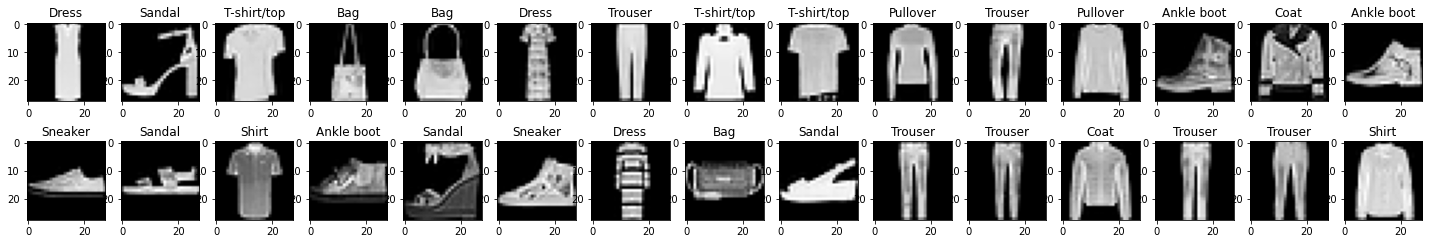

In [47]:
# Obtain one batch of training images
# iter(): turn the object to the iterator
dataiter = iter(train_loader)

# .next() to move to the next element 
images, labels = dataiter.next()

# Convert the  tensor object into an numpy.ndarray object
images = images.numpy()

# Plot the iamges in the batch, along with the coressponding labels
fig = plt.figure(figsize=(25,4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, )
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

In [48]:
# Get the shape of the each image
images[1].shape

# Here: (1, 28, 28) it means it has the dimension(width/height) = 28

(1, 28, 28)

In [49]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # 1 input image channel(gray scale), 10 output channels/feature maps
        # 3x3 square convolutional kernel
        # W: width/height of the input image
        # F: filter size
        # SL size of stride
        # Output size = (W-F)/S + 1
        # Output size = (W-F)/S + 1 = (28-3)/1 + 1 = 26
        # The output tensor for one image, will have the dimensions: (10,26,26)
        # After one pool layer, this becomes (10, 13, 13) 
        self.conv1 = nn.Conv2d(1, 10, 3)

        # Define the maxpool layer(kernel_size = 2, stride =2)
        self.pool = nn.MaxPool2d(2,2)

        # Define the second conv layerL 10 inputs, 20 outputs, 3x3 conv
        # Output size = (W-F)/S + 1 = (13-3)/1 + 1 = 11
        # The output tensor will have the dimensions: (20, 11, 11)
        # after another pool layer this becomes (20, 5.5, 5.5) but it is rounded down to (20, 5, 5)
        self.conv2 = nn.Conv2d(10, 20, 3)

        # 20 outputs * the 5*5 filterd/pooled map size = 20*5*5 = 500 hidden units after the second convolutional layer
        # 10 output channels(for the 10 classes)
        self.fc1 = nn.Linear(500,50)

        # Dropout with p=0.4
        self.fc1_drop = nn.Dropout(p=0.4)

        # Finally, create 10 output channels (for the 10 classes)
        self.fc2 = nn.Linear(50,10)

    # Define the feedforward behavior
    def forward(self, x):
        # two conv/relu + pool layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Prepare for linear layer
        # Flatten the inputs into a vector
        x = x.view(x.size(0), -1)

        # Two linear layer with dropout in between
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        
        # a softmax layer to convert the 10 outputs into a distribution of class scores
        x = F.log_softmax(x, dim=1)
        
        # final output
        return x
    
    # instantiate and print your Net
net = Net()
print(net)

    


Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


### Loss function

In [50]:
import torch.optim as optim
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr= 0.001)


### Train the network


In [51]:
from torch.autograd import Variable
def train(n_epochs):

    # Track the loss as the network trains
    loss_over_time = []
    
    for epoch in range(n_epochs):
        running_loss = 0.0
        for batch_i, data in enumerate(train_loader):
            # Get the input images and their corresponding labels
            inputs, labels = data

            # Zero the parameter(weight) gradients
            optimizer.zero_grad()

            # Forward pass to get outputs
            outputs = net(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backward pass to calculate the parameter gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()

            # Print loss statistics
            # # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time

In [52]:
# define the number of epochs to train for
n_epochs = 30

# call train and record the loss over time
training_loss = train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 2.293360452413559
Epoch: 1, Batch: 2000, Avg. Loss: 2.2537832078933717
Epoch: 2, Batch: 1000, Avg. Loss: 2.1456607698202133
Epoch: 2, Batch: 2000, Avg. Loss: 1.7883263988494873
Epoch: 3, Batch: 1000, Avg. Loss: 1.383738431453705
Epoch: 3, Batch: 2000, Avg. Loss: 1.1908505037426949
Epoch: 4, Batch: 1000, Avg. Loss: 1.1065657184123994
Epoch: 4, Batch: 2000, Avg. Loss: 1.0287162836790085
Epoch: 5, Batch: 1000, Avg. Loss: 0.987476070702076
Epoch: 5, Batch: 2000, Avg. Loss: 0.9570133265554905
Epoch: 6, Batch: 1000, Avg. Loss: 0.9276004166901112
Epoch: 6, Batch: 2000, Avg. Loss: 0.9077047706544399
Epoch: 7, Batch: 1000, Avg. Loss: 0.8850223131477832
Epoch: 7, Batch: 2000, Avg. Loss: 0.8675049758553505
Epoch: 8, Batch: 1000, Avg. Loss: 0.8491938845813274
Epoch: 8, Batch: 2000, Avg. Loss: 0.8444913777410984
Epoch: 9, Batch: 1000, Avg. Loss: 0.8251778851151467
Epoch: 9, Batch: 2000, Avg. Loss: 0.8154251892566681
Epoch: 10, Batch: 1000, Avg. Loss: 0.804605345964

### Visualize the loss

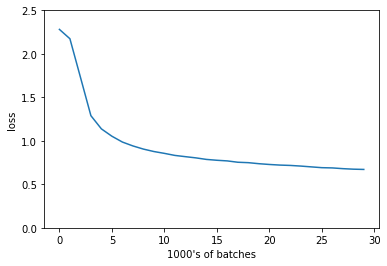

In [43]:
# visualize the loss as the network trained
plt.plot(training_loss)
plt.xlabel('1000\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 2.5) # consistent scale
plt.show()

### Calculate the loss

In [44]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.605585

Test Accuracy of T-shirt/top: 77% (770/1000)
Test Accuracy of Trouser: 92% (921/1000)
Test Accuracy of Pullover: 71% (710/1000)
Test Accuracy of Dress: 84% (844/1000)
Test Accuracy of  Coat: 67% (674/1000)
Test Accuracy of Sandal: 89% (894/1000)
Test Accuracy of Shirt: 16% (161/1000)
Test Accuracy of Sneaker: 86% (867/1000)
Test Accuracy of   Bag: 92% (929/1000)
Test Accuracy of Ankle boot: 94% (940/1000)

Test Accuracy (Overall): 77% (7710/10000)


C:\Users\PC\AppData\Local\Temp/ipykernel_14000/1365830151.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  preds = np.squeeze(net(Variable(images, volatile=True)).data.max(1, keepdim=True)[1].numpy())
C:\Users\PC\AppData\Local\Temp/ipykernel_14000/1365830151.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])


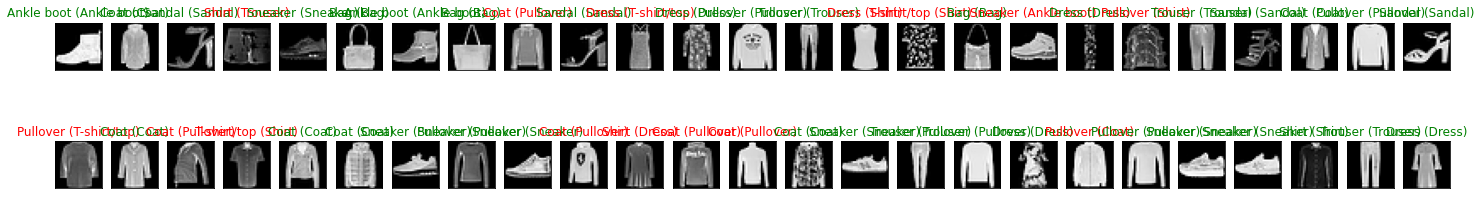

In [45]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(net(Variable(images, volatile=True)).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### Saving the model

In [38]:
# Saving the model
model_dir = 'D:/ComputerVision/model'
model_name = 'fashion_net_simple.pt'

# after training, save your model parameters in the dir 'saved_models'
# when you're ready, un-comment the line below
torch.save(net.state_dict(), model_dir+model_name)